In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import TPmod
import brewtools
import nestkit_modified as nestkit

from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian1DKernel
from pymultinest.analyse import Analyzer
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter, FuncFormatter, LogLocator, MultipleLocator

import warnings
warnings.filterwarnings('ignore')

In [3]:
fontsize = 8
labelsize=12

tick_labelsize=10

tick_length = 5
tick_width = 1

fig_width = 3.5

fig_width_2 = 7.25

In [4]:
object_name = "W0359"

runname = "W0359_5_knots"

argfile = "/Users/harshil/PycharmProjects/Brewster/Retrieved_results/Nested_sampling_files/W0359/WO_sfs/" + runname + "_runargs.pic"

runargs = brewtools.pickle_load(argfile)

gases_myP, chemeq, dist, dist_err, cloudtype, do_clouds, gasnum, gaslist, cloudnum, inlinetemps, coarsePress, press, inwavenum, linelist, cia, ciatemps, use_disort, fwhm, obspec, proftype, do_fudge, prof, do_bff, bff_raw, ceTgrid, metscale, coscale, wavelength_cutoff, sf, sf_err = runargs

ndim, pnames = nestkit.countdims(runargs, plist=True)
a = Analyzer(ndim, outputfiles_basename="/Users/harshil/PycharmProjects/Brewster/Retrieved_results/Nested_sampling_files/W0359/WO_sfs/" + runname)
stats = a.get_stats()
bestfit_params = a.get_best_fit()

theta_max = np.array(bestfit_params['parameters'])

  analysing data from /Users/harshil/PycharmProjects/Brewster/Retrieved_results/Nested_sampling_files/W0359/WO_sfs/W0359_5_knots.txt


In [5]:
Tlays = np.loadtxt('/Users/harshil/PycharmProjects/Brewster/Retrieved_results/Retrieved_thermal_profile/'+object_name+'_thermal_profile_wo_sfs.txt')

In [6]:
BesTprof = TPmod.set_prof(proftype,coarsePress,press,theta_max[ndim-5:])
logP = np.log10(press)

In [7]:
# get diagnostics along with the spectrum
gnostics = 1
shiftspec, clphotspec, ophotspec,cfunc = nestkit.modelspec(theta_max,runargs,gnostics)

nwave = inwavenum.size
cfunc = np.reshape(cfunc,[cfunc.shape[1],cfunc.shape[2]])
fwhm = 0.005
wlen = shiftspec.shape[1]
wint =  shiftspec[0,0] - shiftspec[0,wlen-1]
# convolve with instrumental profile
# start by setting up kernel
# First step is finding the array index length of the FWHM
disp = wint / wlen
gwidth = int((((fwhm / disp) // 2) * 2) +1)
# needs to be odd
# now get the kernel and convolve
gauss = Gaussian1DKernel(gwidth)

for ilayer in range (0,press.size):
    cfunc[:,ilayer] = convolve(cfunc[:,ilayer],gauss,boundary='extend')

#tau1_cl_Press = convolve(clphotspec[0],gauss,boundary='extend')[::-1]
tau1_oth_Press = convolve(ophotspec[0],gauss,boundary='extend')[::-1]

wavenew = shiftspec[0,::-1]
press = press.reshape(64,)
normfunc = np.zeros_like(cfunc)
for iwave in range(0,nwave):
    totcont = np.sum(cfunc[iwave,:])
    normfunc[iwave,:] = cfunc[iwave,:] / totcont

In [8]:
factor = np.zeros(len(press))
for i in range(len(press)):
    factor[i] = 1 / max(normfunc[::-1, i])

normalize = np.zeros(np.shape(normfunc))
for i in range(len(factor)):
    normalize[:, i] = factor[i] * normfunc[::-1, i]
hst_wave_cont = np.where((wavenew >= 1) & (wavenew <= 1.7))
webb_wave_cont = np.where((wavenew >= 1.7) & (wavenew <= 13.0))

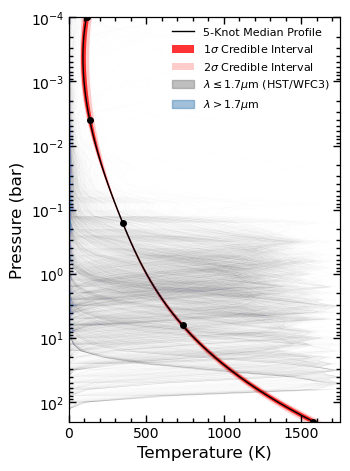

In [9]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width*1.5))

ax.axis([0., 2000.,(max(press)),(min(press)),])

plt.rc('font',family='sans serif')

ax.set_ylabel(r'Pressure (bar)', size=labelsize)
ax.set_xlabel('Temperature (K)', size=labelsize)

BesTprof = TPmod.set_prof(proftype,coarsePress,press,theta_max[ndim-5:])

logP = (press)

ax.plot(Tlays[:,2],logP,'k-',linewidth=1, label='5-Knot Median Profile', zorder=3)
ax.fill_betweenx(logP,Tlays[:,1], Tlays[:,3], facecolor='red', alpha=0.8, label='1$\sigma$ Credible Interval', zorder=1)
ax.fill_betweenx(logP,Tlays[:,0], Tlays[:,4], facecolor='red', alpha=0.2, label='2$\sigma$ Credible Interval', zorder=1)

handles, labels = plt.gca().get_legend_handles_labels()

ax2 = ax.twiny()
ax2.plot(normalize[hst_wave_cont[0][0::5], :].transpose(), (press), linewidth=0.05, color='gray', alpha=0.05, zorder=0)
ax2.plot(normalize[webb_wave_cont[0][0::10], :].transpose(), (press), linewidth=0.05, color='steelblue', alpha=0.05, zorder=1)
ax2.axis([0.,1, (press[-1]),(press[0])])
plt.tick_params(labeltop = False, top = False)

#ax2.plot([0.9,0.9], [2.06,-0.1],color = 'blue', marker = '_')
#ax2.plot([0.8,0.8], [1.25,-1.2],color = 'blue', marker = '_')

ax.tick_params(axis='both',which='major', direction='in', top=True, right=True, length=tick_length, width=tick_width, labelsize=tick_labelsize)
ax.tick_params(axis='both',which='minor', direction='in',  top=True, right=True, length=0.6*tick_length, width=tick_width, labelsize=tick_labelsize)

ax.xaxis.set_minor_locator(AutoMinorLocator())
#ax.yaxis.set_minor_locator(AutoMinorLocator())

hst_cont_legend = mpatches.Patch(color='gray', linestyle='-', linewidth=1, alpha=0.5, label="$\lambda \leq 1.7 \mu$m (HST/WFC3)")
jwst_cont_legend = mpatches.Patch(color='steelblue', linestyle='-', linewidth=1, alpha=0.5, label="$\lambda > 1.7 \mu$m")

handles.extend([hst_cont_legend, jwst_cont_legend])

#plt.xticks(fontsize=labelsize)
#plt.yticks(fontsize=labelsize)
ax.set_xlim(0,1750)
ax.set_yscale('log')
ax2.set_yscale('log')

press_index=[0,16,32,48,63]

markersize = 4

for i in range(len(press_index)):
    ax.plot(Tlays[:,2][press_index[i]], logP[press_index[i]], 'ko', markersize=markersize)

#ax.legend(handles=handles, fontsize=17, frameon=False)
plt.legend(handles=handles, fontsize=fontsize, frameon=False)

plt.savefig('/Users/harshil/Documents/Retreival_results/W0359/WO_sfs/Thermal_profile.pdf',format='pdf', bbox_inches = "tight")

plt.show()